In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

In [4]:
data = pd.read_csv('Crude.csv')
data.head()

,Date,Closing Value
0,02-01-1986,25.56
1,03-01-1986,26.00
2,06-01-1986,26.53
3,07-01-1986,25.85
4,08-01-1986,25.87


In [3]:
data.tail()

,Date,Closing Value
9559,02-10-2023,88.47
9560,03-10-2023,89.39
9561,04-10-2023,84.37
9562,05-10-2023,82.89
9563,06-10-2023,82.79


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9564 non-null   object 
 1   Closing Value  9557 non-null   float64
dtypes: float64(1), object(1)
memory usage: 149.6+ KB


In [5]:
data.describe()

,Closing Value
count,9557.000000
mean,46.789439
std,29.615017
min,10.250000
25%,20.090000
50%,37.700000
75%,69.380000
max,145.310000


In [5]:
data.isnull().sum()

Date             0
Closing Value    7
dtype: int64

In [6]:
import numpy as np

mean_value = data['Closing Value'].mean()
data['Closing Value'].fillna(mean_value, inplace = True)
data.rename(columns={'Closing Value': 'value'}, inplace=True)
data.head()

,Date,value
0,02-01-1986,25.56
1,03-01-1986,26.00
2,06-01-1986,26.53
3,07-01-1986,25.85
4,08-01-1986,25.87


In [7]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace = True)
data.sort_index(inplace = True)

In [8]:
data.head()

,value
Date,
1986-01-04,11.13
1986-01-05,13.80
1986-01-07,12.39
1986-01-08,11.56
1986-01-10,15.23


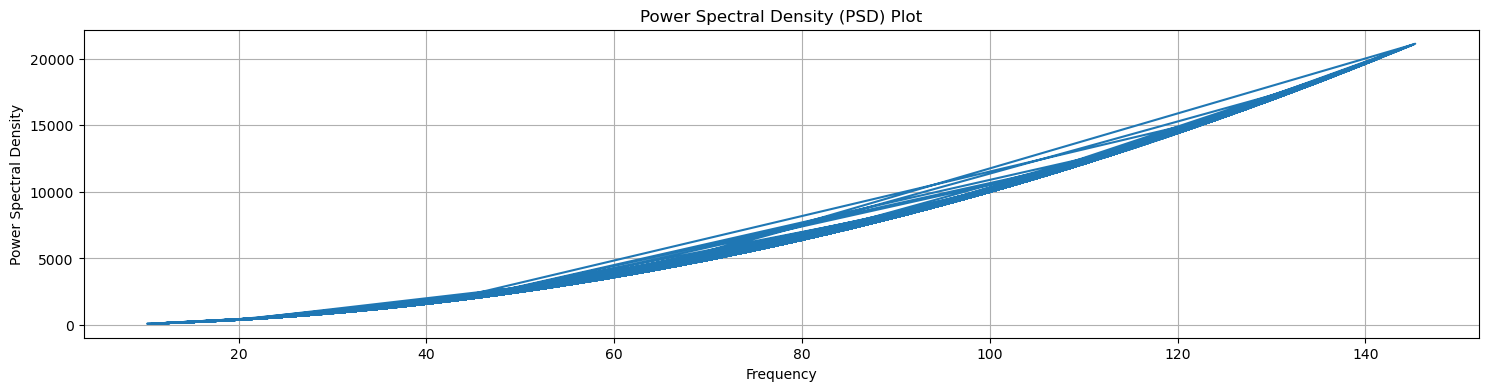

In [15]:
import numpy as np
import matplotlib.pyplot as plt

fftResult = np.fft.fft(data) # convert to time domain
fftFreq = np.fft.fftfreq(len(data)) #frequency components of data

PSD = np.abs(fftResult) ** 2

plt.figure(figsize=(18,4))
plt.plot(fftResult, PSD)
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectral Density (PSD) Plot')
plt.grid()
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller
# Now you can use the new column name in the ADF test
result = adfuller(data['value'])

# Print the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Check the p-value to determine stationarity
if result[1] <= 0.05:
    print("The time series is likely stationary.")
else:
    print("The time series is likely non-stationary.")

ADF Statistic: -1.8562231607109272
p-value: 0.35292684683500297
Critical Values: {'1%': -3.4310367257937258, '5%': -2.86184349028407, '10%': -2.5669315427725077}
The time series is likely non-stationary.


In [10]:
df_log=np.sqrt(data['value'])
df_diff=df_log.diff().dropna()
#Checking the stationarity

result=adfuller (df_diff)
print('Test Statistic: %f' %result[0])
print('p-value: %f' %result[1])
print('Critical values:')
for key, value in result[4].items ():
     print('\t%s: %.3f' %(key, value))

Test Statistic: -15.556803
p-value: 0.000000
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [11]:
from statsmodels.tsa.stattools import adfuller
# Now you can use the new column name in the ADF test
result = adfuller(df_diff)

# Print the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Check the p-value to determine stationarity
if result[1] <= 0.05:
    print("The time series is likely stationary.")
else:
    print("The time series is likely non-stationary.")

ADF Statistic: -15.556803285247716
p-value: 2.066524484063024e-28
Critical Values: {'1%': -3.43103679791794, '5%': -2.861843522154823, '10%': -2.566931559737411}
The time series is likely stationary.


In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_resampled = data.resample('Q').mean().ffill()
df_resampled.index.freq = 'Q'
decomposition = seasonal_decompose(df_resampled['value'], model = 'additive')

In [13]:
df_resampled.head()

,value
Date,
1986-03-31,15.991935
1986-06-30,14.404194
1986-09-30,14.524375
1986-12-31,15.283333
1987-03-31,18.692419


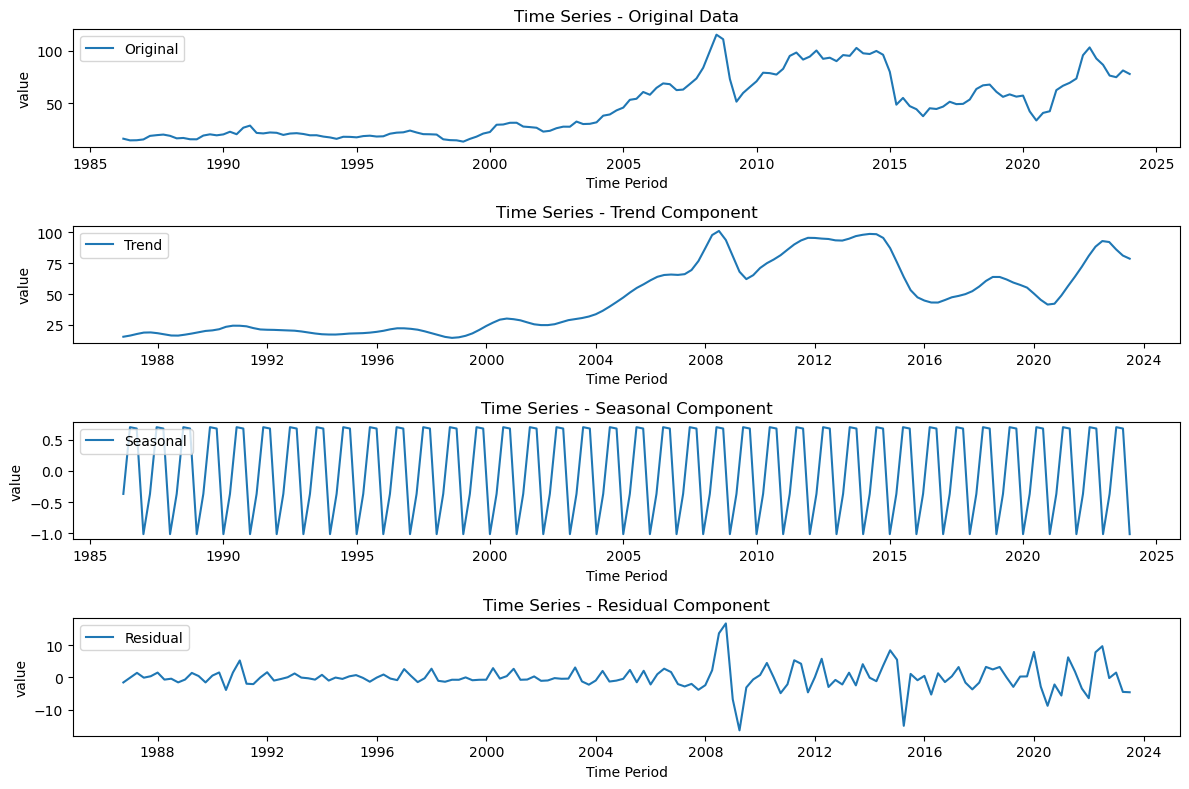

In [25]:
plt.figure(figsize =(12,8))

plt.subplot(411)
plt.plot(df_resampled['value'], label = 'Original')
plt.legend(loc = 'upper left')
plt.title('Time Series - Original Data')
plt.xlabel('Time Period')
plt.ylabel('value')

plt.subplot(412)
plt.plot(decomposition.trend, label = 'Trend')
plt.legend(loc = 'upper left')
plt.title('Time Series - Trend Component')
plt.xlabel('Time Period')
plt.ylabel('value')

plt.subplot(413)
plt.plot(decomposition.seasonal, label = 'Seasonal')
plt.legend(loc = 'upper left')
plt.title('Time Series - Seasonal Component')
plt.xlabel('Time Period')
plt.ylabel('value')

plt.subplot(414)
plt.plot(decomposition.resid, label = 'Residual')
plt.legend(loc = 'upper left')
plt.title('Time Series - Residual Component')
plt.xlabel('Time Period')
plt.ylabel('value')

plt.tight_layout()
plt.show()

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [16]:
p = d = q = range(0,2)
pdq = list(product(p,d,q))

In [17]:
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in pdq]

In [18]:
best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None

In [19]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(df_resampled['value'],
                          order = param,
                          seasonal_order = param_seasonal,
                          enforce_stationarity = False,
                          enforce_invertibility = False)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue

In [20]:
best_aic, best_pdq, best_seasonal_pdq

(952.7896476206015, (0, 1, 1), (0, 1, 1, 4))

In [21]:
best_model = SARIMAX(df_resampled['value'],
                    order = best_pdq,
                    seasonal_order = best_seasonal_pdq,
                    enforce_stationarity= False,
                    enforce_invertibility= False)
best_results = best_model.fit()

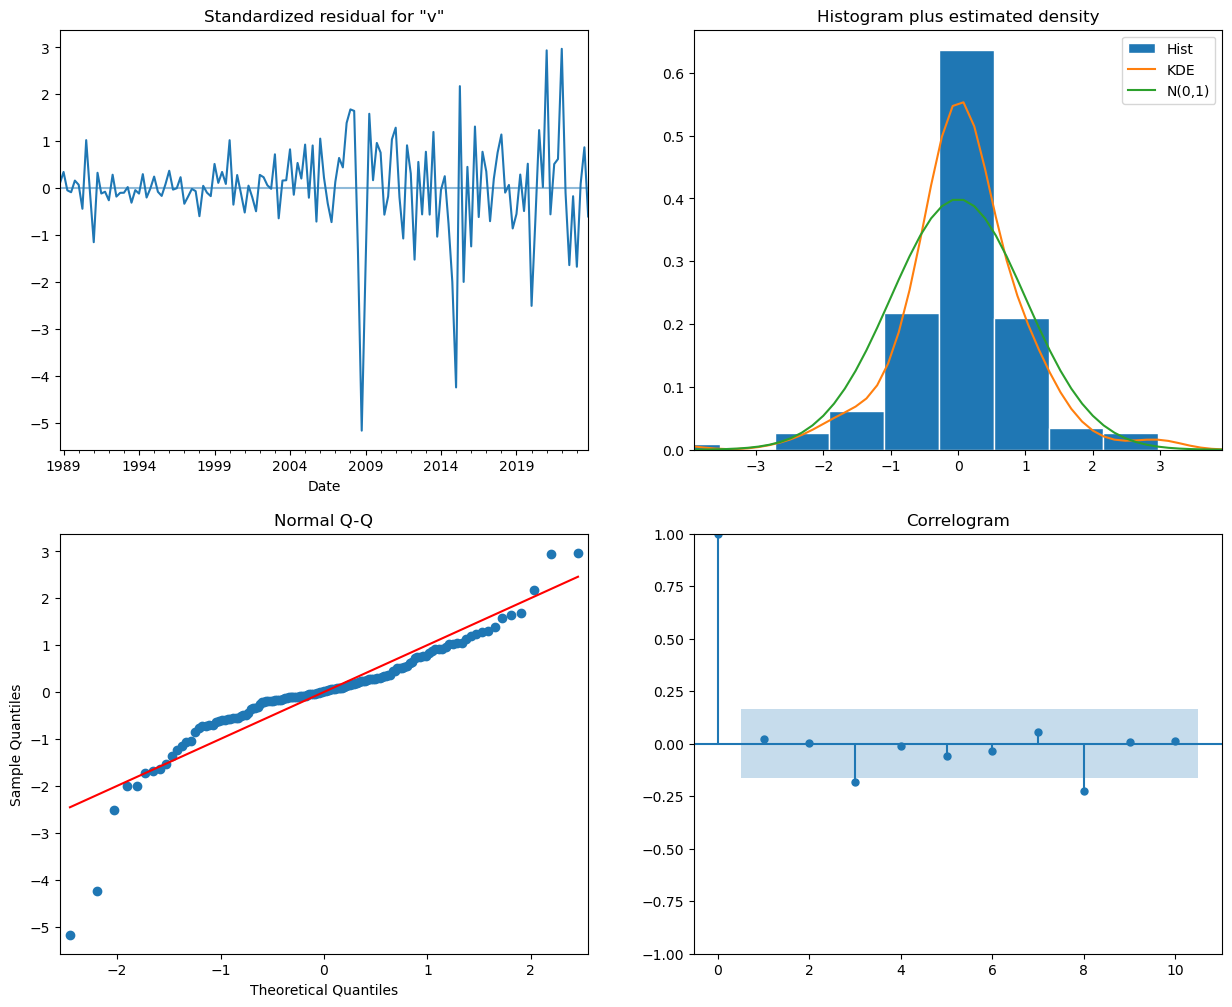

In [33]:
best_results.plot_diagnostics(figsize = (15, 12))
plt.show()

In [22]:
forecast = best_results.get_forecast(steps = 30)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

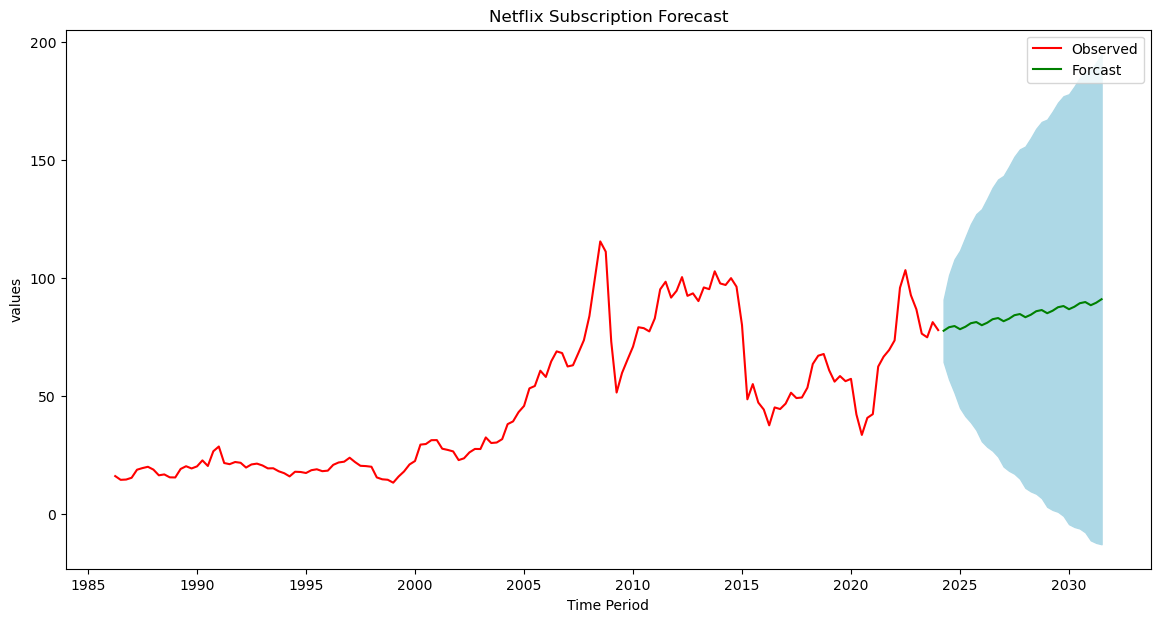

In [53]:
plt.figure(figsize = (14,7))
plt.plot(df_resampled.index, df_resampled['value'], label = 'Observed', color = 'red')
plt.plot(mean_forecast.index, mean_forecast, label ='Forcast', color = 'green')
plt.fill_between(confidence_intervals.index,
                confidence_intervals.iloc[:,0],
                confidence_intervals.iloc[:, 1], color = 'lightblue')
plt.xlabel('Time Period')
plt.ylabel('values')
plt.title('Netflix Subscription Forecast')

plt.legend()
plt.show()

In [36]:
mean_forecast

2024-03-31    77.624702
2024-06-30    79.123692
2024-09-30    79.621232
2024-12-31    78.282591
2025-03-31    79.320942
2025-06-30    80.819932
2025-09-30    81.317472
2025-12-31    79.978831
2026-03-31    81.017182
2026-06-30    82.516172
2026-09-30    83.013712
2026-12-31    81.675071
2027-03-31    82.713421
2027-06-30    84.212411
2027-09-30    84.709951
2027-12-31    83.371310
2028-03-31    84.409661
2028-06-30    85.908651
2028-09-30    86.406191
2028-12-31    85.067550
2029-03-31    86.105901
2029-06-30    87.604891
2029-09-30    88.102431
2029-12-31    86.763790
2030-03-31    87.802141
2030-06-30    89.301130
2030-09-30    89.798671
2030-12-31    88.460029
2031-03-31    89.498380
2031-06-30    90.997370
Freq: Q-DEC, Name: predicted_mean, dtype: float64

In [37]:
from statsmodels.tsa.arima.model import ARIMA

In [38]:
best_aic_arima = float("inf")
best_pdq_arima = None

for param in pdq:
    try:
        model_arima = ARIMA(df_resampled['value'], order=param)
        results_arima = model_arima.fit()
        if results_arima.aic < best_aic_arima:
            best_aic_arima = results_arima.aic
            best_pdq_arima = param
    except:
        continue

best_aic_arima, best_pdq_arima

(1000.7121201053244, (0, 1, 1))

In [1]:
import pickle

In [23]:
filename = 'forecast_model.pkl'
pickle.dump(forecast, open(filename, 'wb'))